In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
# Reading the dataset

df = pd.read_csv('insurance.csv')

In [3]:
df.head().T

,0,1,2,3,4
age,19,18,28,33,32
sex,female,male,male,male,male
bmi,27.9,33.77,33.0,22.705,28.88
children,0,1,3,0,0
smoker,yes,no,no,no,no
region,southwest,southeast,southeast,northwest,northwest
charges,16884.924,1725.5523,4449.462,21984.47061,3866.8552


In [4]:
# No missing Values

df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# Splitting the data into target and features

y = df['charges']
X = df.iloc[:,:-1]

In [6]:
# Encoding categorical features and scaling

categorical_cols = list(set(X.columns) - set(X._get_numeric_data().columns))
X = pd.get_dummies(X, columns=categorical_cols,drop_first=True)


from sklearn.preprocessing import StandardScaler

sca = StandardScaler().set_output(transform='pandas')

X = sca.fit_transform(X)


# Splitting into 80/10/10 for train, validation, and test respectivly

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

models = {}



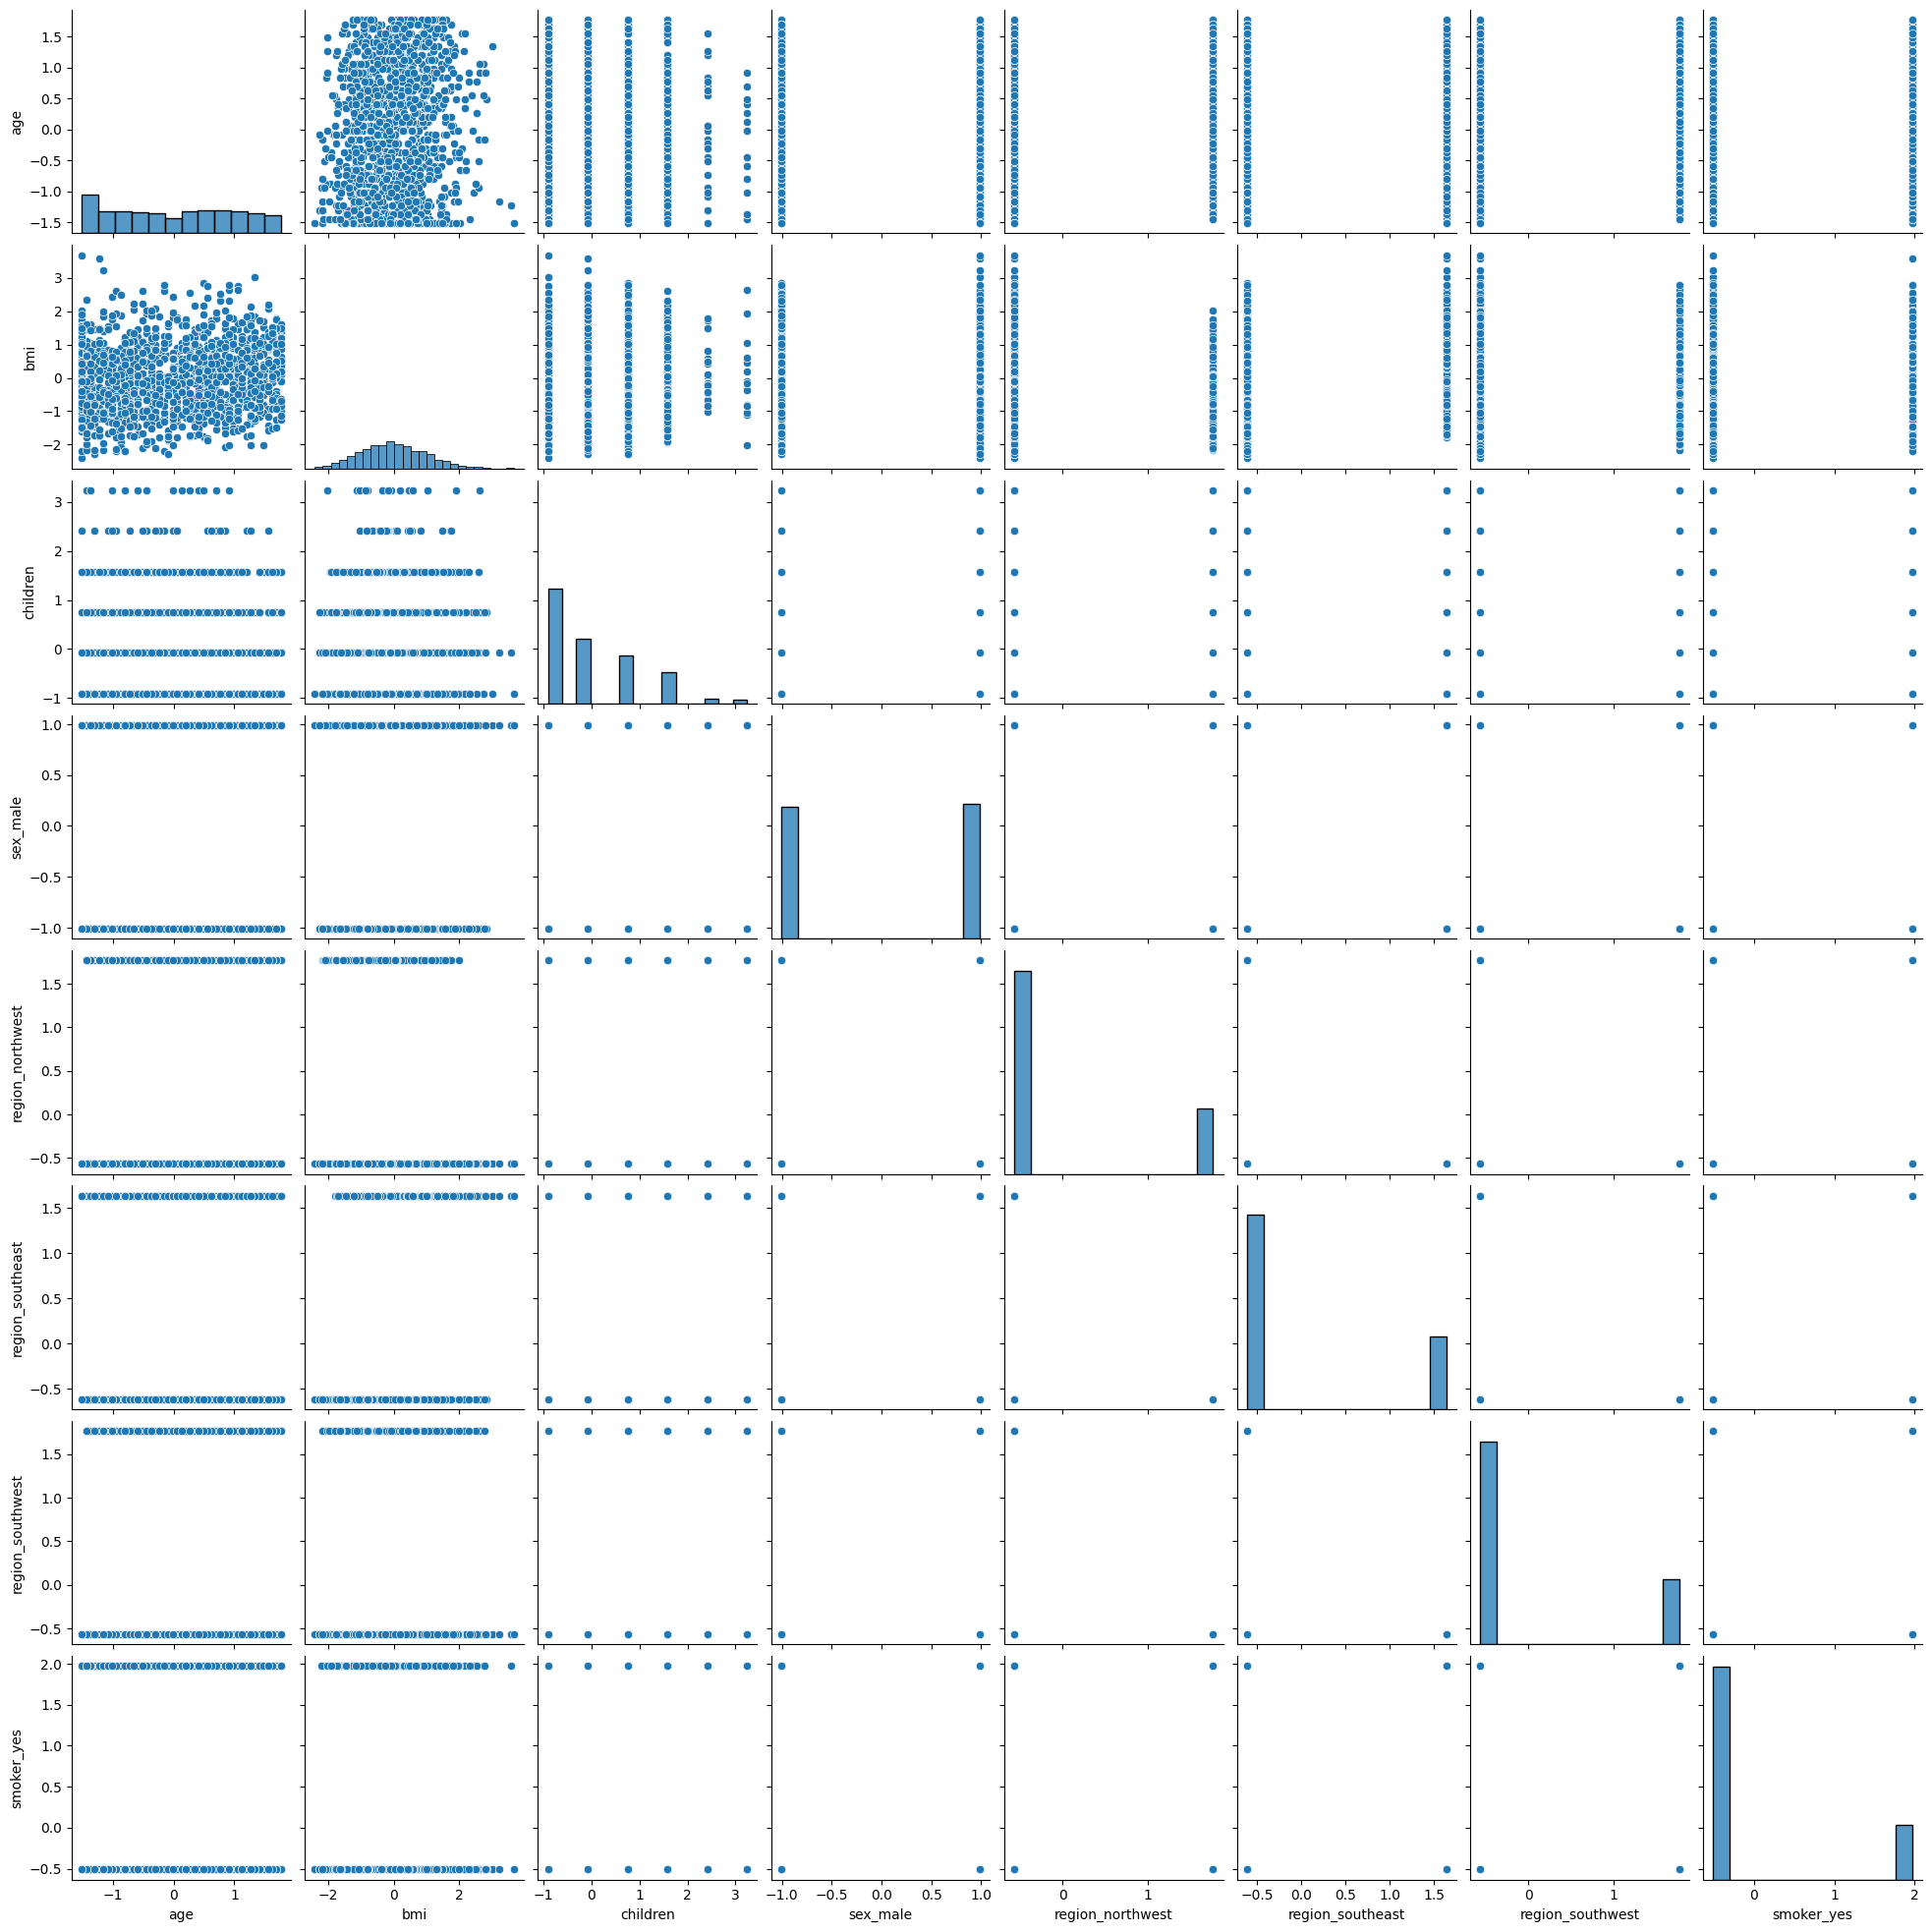

In [8]:
# pairplots. These arent super useful as most of the variables are categorical
sns.pairplot(X)
plt.show()

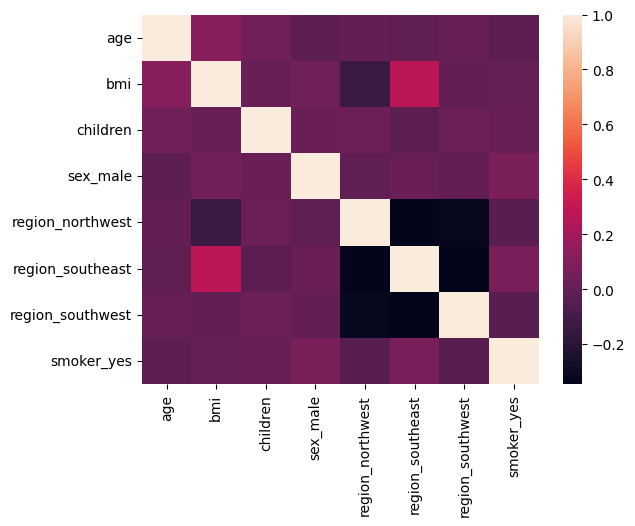

In [9]:
# correlation heatmap, easier to interpret than the pairplots, 
# feature spaces seems mostly uncorrelated (except for the one-hot-encoded region categories as we would expect to see)

corr = X.corr()

sns.heatmap(corr)
plt.show()

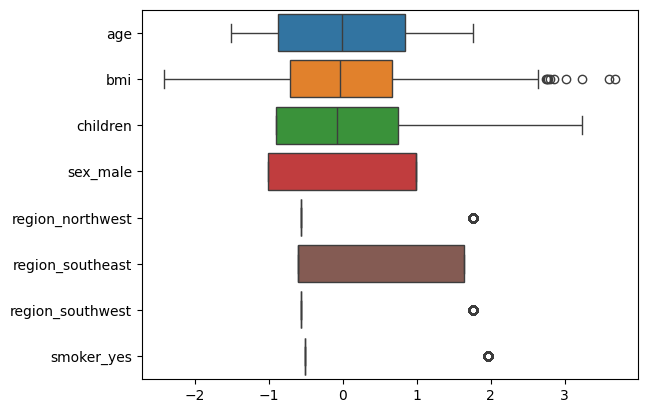

In [11]:
# boxplots
sns.boxplot(X,orient='h')
plt.show()


#### After observing the pair plots and correlation heatmap, we can see that there does not appear to be any major collinearity present. 
#### Looking at the box plots, the features seem mostly balanced except for the number of children.

In [66]:
# We will use optuna to help with hyperparameter tuning

import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


models = {}


/Users/koa/Documents/ML Course/breast cancer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
# Optuna tuning for Decision Tree model. We optimize over criterion, max_depth, min_samples_split and min_samples_leaf.

def objective(trial):
    params = {
    "criterion": trial.suggest_categorical("criterion", ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
    "random_state": 50,
    }

    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    y_predv = model.predict(X_valid)
    score= r2_score(y_valid, y_predv)
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


best_criterion = study.best_params["criterion"]
best_max_depth = study.best_params["max_depth"]
min_samples_split = study.best_params["min_samples_split"]
min_samples_leaf = study.best_params["min_samples_leaf"]
random_state = 50

model = DecisionTreeRegressor(criterion=best_criterion, 
                               max_depth=best_max_depth, min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,random_state=random_state)

model.fit(pd.concat([X_train,X_valid], axis=0),pd.concat([y_train,y_valid]))

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('Decision Tree R-Squared: ',r2)
print('Decision Tree MSE: ',MSE)
print('Decision Tree MAE: ',MAE)

models['Tree'] = (model, r2, MSE, MAE)

[I 2025-02-06 14:47:02,817] A new study created in memory with name: no-name-d7ed626a-2246-422d-8fa9-7225bb7f6db4
[I 2025-02-06 14:47:02,826] Trial 0 finished with value: 0.8184384838278628 and parameters: {'criterion': 'poisson', 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8184384838278628.
[I 2025-02-06 14:47:02,829] Trial 1 finished with value: 0.8260884327879527 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8260884327879527.
[I 2025-02-06 14:47:02,833] Trial 2 finished with value: 0.8185150500729506 and parameters: {'criterion': 'squared_error', 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.8260884327879527.
[I 2025-02-06 14:47:02,835] Trial 3 finished with value: 0.8215702214909849 and parameters: {'criterion': 'friedman_mse', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1

Decision Tree R-Squared:  0.8650826557514683
Decision Tree MSE:  18104016.439265292
Decision Tree MAE:  1688.709205783582


In [ ]:
# Optuna tuning for Random Forest Model

def objective(trial):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    "criterion": trial.suggest_categorical("criterion", ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
    "random_state": 50,
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_predv = model.predict(X_valid)
    score= r2_score(y_valid, y_predv)
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_estimators = study.best_params["n_estimators"]
best_criterion = study.best_params["criterion"]
best_max_depth = study.best_params["max_depth"]
min_samples_split = study.best_params["min_samples_split"]
min_samples_leaf = study.best_params["min_samples_leaf"]
random_state = 50

model = RandomForestRegressor(n_estimators=best_estimators, criterion=best_criterion, 
                               max_depth=best_max_depth, min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,random_state=random_state)

model.fit(pd.concat([X_train,X_valid], axis=0),pd.concat([y_train,y_valid]))
#model.fit(X_train,y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('Rand Forest R-Squared: ',r2)
print('Rand Forest MSE: ',MSE)
print('Rand Forest MAE: ',MAE)

models['Forest'] = (model, r2, MSE, MAE)

[I 2025-02-06 14:48:17,886] A new study created in memory with name: no-name-f8bf1682-831c-4d28-b957-7b99c98c1766


[I 2025-02-06 14:48:18,076] Trial 0 finished with value: 0.8265410056551972 and parameters: {'n_estimators': 190, 'criterion': 'friedman_mse', 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8265410056551972.
[I 2025-02-06 14:48:18,188] Trial 1 finished with value: 0.829364368828516 and parameters: {'n_estimators': 180, 'criterion': 'friedman_mse', 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.829364368828516.
[I 2025-02-06 14:48:18,322] Trial 2 finished with value: 0.8264286567807717 and parameters: {'n_estimators': 140, 'criterion': 'poisson', 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.829364368828516.
[I 2025-02-06 14:48:18,554] Trial 3 finished with value: 0.8248700983540916 and parameters: {'n_estimators': 250, 'criterion': 'poisson', 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.829

Rand Forest R-Squared:  0.8638798753438188
Rand Forest MSE:  18265412.710398532
Rand Forest MAE:  2462.787365119007


In [30]:
# Optuna tuning for SVR model

def objective(trial):
    params = {
    "kernel": trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
    "degree": trial.suggest_int("degree", 1, 6),
    "C": trial.suggest_float("C", 0.01, 10000),
    "epsilon": trial.suggest_float("epsilon", 0.01, 50),
    }

    model = SVR(**params)
    model.fit(X_train, y_train)
    y_predv = model.predict(X_valid)
    score= r2_score(y_valid, y_predv)
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000)

best_kernel = study.best_params["kernel"]
best_degree = study.best_params["degree"]
best_C = study.best_params["C"]
best_epsilon = study.best_params["epsilon"]


model = SVR(kernel=best_kernel, degree=best_degree, C=best_C, epsilon=best_epsilon)

model.fit(pd.concat([X_train,X_valid], axis=0),pd.concat([y_train,y_valid]))

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print('SVR R-Squared: ',r2)
print('SVR MSE: ',MSE)
print('SVR MAE: ',MAE)

models['SVR'] = (model, r2, MSE, MAE)

[I 2025-02-05 18:19:06,635] A new study created in memory with name: no-name-aeeb33e5-9424-4a92-afa2-1f8e06dae7c0
[I 2025-02-05 18:19:06,769] Trial 0 finished with value: 0.8688237299961972 and parameters: {'kernel': 'rbf', 'degree': 2, 'C': 8935.593149747921, 'epsilon': 43.413101253550494}. Best is trial 0 with value: 0.8688237299961972.
[I 2025-02-05 18:19:06,803] Trial 1 finished with value: -0.4280880083398255 and parameters: {'kernel': 'sigmoid', 'degree': 1, 'C': 2643.792258275923, 'epsilon': 24.32344150967776}. Best is trial 0 with value: 0.8688237299961972.
[I 2025-02-05 18:19:06,860] Trial 2 finished with value: 0.8659051219001686 and parameters: {'kernel': 'rbf', 'degree': 1, 'C': 2638.7928564606514, 'epsilon': 4.540982621471989}. Best is trial 0 with value: 0.8688237299961972.
[I 2025-02-05 18:19:07,008] Trial 3 finished with value: 0.6373270920779309 and parameters: {'kernel': 'linear', 'degree': 3, 'C': 8810.799351555697, 'epsilon': 32.55861145667499}. Best is trial 0 with

SVR R-Squared:  0.8529371845307818
SVR MSE:  15714964.348145613
SVR MAE:  1415.5744962796878


#### Comparing the 3 tuned and trained models, we see the best R-Squared scores and lowest MSE in the Random Forest model, slightly behind in both these metrics is the Decision tree model, then the SVR model is the worst performing with a much lower R-Squared.

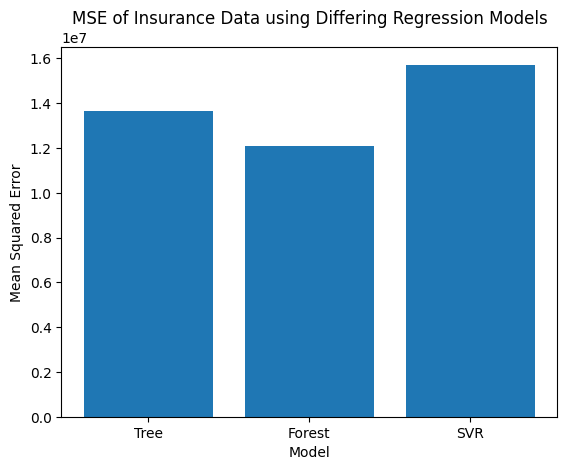

In [31]:
mses = []
model_names = []
for key in models:
    mses.append(models[key][2])
    model_names.append(key)


plt.bar(model_names, mses)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('MSE of Insurance Data using Differing Regression Models')


plt.show()

### Here we can see a comparison of the MSE of the 3 models, we see the Random Forest model is the best performing of the three.

In [98]:
# Storing the models and frames to pickles for future use.

def export_to_pickle(models_dict,X_train, X_test, y_train, y_test, X, y):
    import pickle
    path = 'insurance_models'
    for key in models_dict.keys():
        pickle.dump(models_dict[key][0], open('insurance_models/'+key+'.pkl', 'wb'))

    dfs = [X_train, X_test, y_train, y_test, X, y]
    pickle.dump(dfs, open('insurance_models/dataframes.pkl', 'wb'))



export_to_pickle(models, pd.concat([X_train, X_valid], axis=0), X_test, pd.concat([y_train, y_valid]), y_test, X, y)

In [25]:
# Unpickling models 

models = {}
path = 'insurance_models'


def unpickle_models(path):
    out = {}
    import pickle
    from os import walk
    file_names = next(walk(path), (None, None, []))[2]
    for file in file_names:
        with open(path+'/'+file, 'rb') as pickleFile:
            out[file[:-4]] = pickle.load(pickleFile)
    return out


models_import = unpickle_models(path)


### ANN Approach

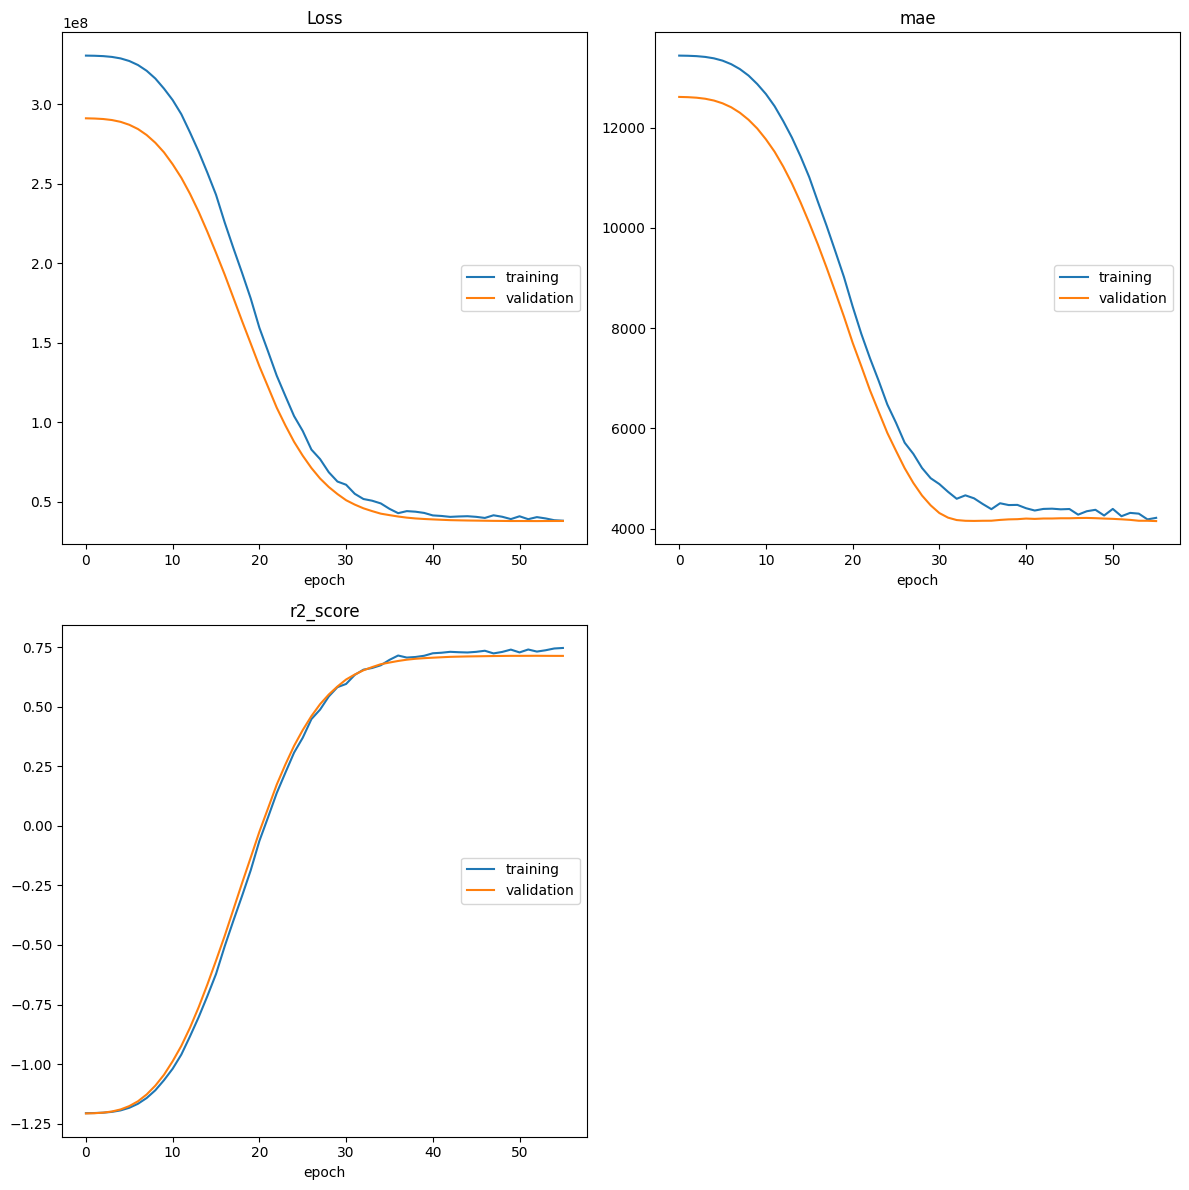

Loss
	training         	 (min: 37993600.000, max: 330433568.000, cur: 37993600.000)
	validation       	 (min: 37762936.000, max: 291005440.000, cur: 37822404.000)
mae
	training         	 (min: 4184.284, max: 13440.630, cur: 4215.172)
	validation       	 (min: 4150.653, max: 12616.002, cur: 4150.653)
r2_score
	training         	 (min:   -1.206, max:    0.746, cur:    0.746)
	validation       	 (min:   -1.207, max:    0.714, cur:    0.713)
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 42304484.0000 - mae: 4457.7817 - r2_score: 0.7305 - val_loss: 37822404.0000 - val_mae: 4150.6533 - val_r2_score: 0.7131
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34321688.0000 - mae: 3889.2498 - r2_score: 0.7206 


In [98]:
import keras
import keras_tuner
from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout



model = Sequential()

model.add(Dense(units=50, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(units=50, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
#model.add(Dense(units=20, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(rate=0.35, seed=0))
model.add(Dense(units=1, activation='relu'))


model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mae', 'r2_score'])

# Add early stopping
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=0.01,
                            patience=3,
                            verbose=0, mode='auto')

#tuner2 = keras_tuner.RandomSearch(build_model, objective='val_loss', max_trials=20, overwrite=True)
#tuner2.search(X_train,y_train, epochs=50, validation_data = (X_valid, y_valid))
#best_model = tuner2.get_best_models()[0]

model.fit(X_train, y_train, batch_size=30, epochs=200, 
          validation_data =(X_valid,y_valid),
          callbacks=[PlotLossesKeras(),callbacks])


loss1, mae1, r2_1 = model.evaluate(X_test, y_test)

In [99]:
print(r2_1)

0.7682396173477173


In [100]:
import keras
import keras_tuner
from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout


def build_model(hp):
    model = Sequential()

    model.add(Dense(units=hp.Choice('units', [30,40,45,50,55,60,70,75]), activation='relu', kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dense(units=hp.Choice('units', [30,40,45,50,55,60,70,75]), activation='relu', kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dropout(hp.Float('rate',min_value=0,max_value=0.6,step=0.1), seed=0))
    model.add(Dense(units=1))


    model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mae','r2_score'])

    # Add early stopping
    callbacks = keras.callbacks.EarlyStopping(monitor='val_loss',
                                min_delta=0.001,
                                patience=5,
                                verbose=0, mode='auto')
    return model
tuner2 = keras_tuner.RandomSearch(build_model, objective='val_loss', max_trials=40, overwrite=True)
tuner2.search(X_train,y_train, epochs=70, validation_data = (X_valid, y_valid), batch_size=32)
best_model = tuner2.get_best_models()[0]

#model.fit(X_train, y_train, batch_size=20, epochs=200, 
#          validation_data =(X_test,y_test),
#          callbacks=[PlotLossesKeras(),callbacks])


loss2, mae2, r2_2 = best_model.evaluate(X_test, y_test)

Trial 40 Complete [00h 00m 10s]
val_loss: 37241848.0

Best val_loss So Far: 36974560.0
Total elapsed time: 00h 06m 41s


/Users/koa/Documents/ML Course/breast cancer/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33208836.0000 - mae: 3936.1458 - r2_score: 0.7297  


In [101]:
print(r2_2)

0.7743053436279297


In [102]:
best_hps2 = tuner2.get_best_hyperparameters()[0]
print(best_hps2.values)

{'units': 40, 'rate': 0.1}


In [103]:
import keras
import keras_tuner
from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout

def build_model(hp):
    model = Sequential()
    # Layers
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=30, max_value=70, step=5),
                        activation=hp.Choice('activation', ['relu', 'tanh', 'elu']),
                        kernel_regularizer=regularizers.l1_l2(
                            l1=hp.Float('l1_reg', 0.01, 0.1),
                            l2=hp.Float('l2_reg', 0.01, 0.1))))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1)) 
    # Optimizer
    optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'r2_score'])
    return model


tuner3 = keras_tuner.Hyperband(build_model, objective='val_loss', max_epochs=70, hyperband_iterations=2, overwrite=True)
tuner3.search(X_train, y_train, epochs=70, validation_data=(X_valid, y_valid), batch_size=32)

# Get the best model
best_model = tuner3.get_best_models()[0]

# Evaluate the best model
loss3, mae3, r2_3 = best_model.evaluate(X_test, y_test)

Trial 180 Complete [00h 00m 19s]
val_loss: 289754944.0

Best val_loss So Far: 25841242.0
Total elapsed time: 00h 38m 33s


/Users/koa/Documents/ML Course/breast cancer/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23259960.0000 - mae: 2738.6724 - r2_score: 0.8103  


In [104]:
print(r2_3)

0.8463065028190613


In [105]:
best_hps3 = tuner3.get_best_hyperparameters()[0]

print(best_hps3.values)

{'num_layers': 2, 'units_0': 70, 'activation': 'elu', 'l1_reg': 0.012217933801302469, 'l2_reg': 0.07250092121402783, 'dropout_rate': 0.0, 'learning_rate': 0.006759117248051905, 'units_1': 40, 'units_2': 65, 'units_3': 70, 'tuner/epochs': 70, 'tuner/initial_epoch': 24, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0138'}
